In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device:",device)

# Define Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 45
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./MNIST_data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./MNIST_data', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Device: cuda


In [2]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
model.load_state_dict(torch.load('model.ckpt'))

<All keys matched successfully>

In [28]:
import scipy.linalg as LA
import numpy as np
import matplotlib.pyplot as plt

W1 = model.fc1.weight.cpu().data
b1 = model.fc1.bias.cpu().data.numpy()
W2 = model.fc2.weight.cpu().data


w1 = W1.numpy()
w2 = W2.numpy()
Nw1 = LA.null_space(w1,rcond=1e-10)

Nw21 = LA.null_space(w2@w1,rcond=1e-10)

def project(vect,Ns):
    proj = np.zeros_like(vect)
    for i in range(Ns.shape[1]):
        proj += vect.dot(Ns[:,i])*Ns[:,i]
    return proj

def get_ns(vect):
    vect = vect.cpu().numpy()
    acts = (w1@vect.reshape(-1, 1) + b1.reshape(-1, 1)).squeeze()
    w1_trunc = w1[acts > 0]
    w2_trunc = w2[:, acts > 0]
    thresh = 0.3
    w_nearzero = w1[np.logical_and(acts < thresh , acts > -thresh)]
    w_effective = w2_trunc@w1_trunc
    print(w_nearzero.shape, w_effective.shape)
    w_total = np.concatenate((w_effective ,w_nearzero), axis=0)
    return LA.null_space(w_total, rcond=1e-10)

In [114]:
Nw21.shape

(784, 774)

In [103]:
acts.shape

(500, 1)

In [30]:
Nw21.shape

(784, 774)

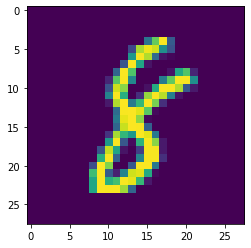

In [33]:
plt.imshow(images[0].cpu())

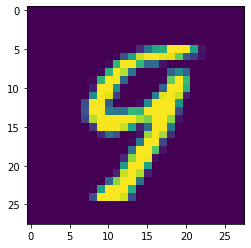

In [32]:
plt.imshow(images[1].cpu())

(66, 784) (10, 784)


/fs/class-projects/fall2021/cmsc828w/cs828w04/anaconda3/envs/class_project_11.1/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor([[2.8477e-10, 1.4249e-09, 2.6479e-07, 1.3989e-03, 4.0663e-06, 2.0266e-06,
         6.9544e-10, 2.1186e-10, 8.2081e-01, 1.7779e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

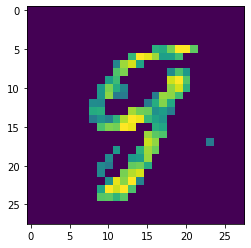

In [40]:
diff_vec = project((images[1] - images[0]).reshape(-1).cpu().numpy() , get_ns(images[0])).reshape(28, 28)
alpha = 1
n_im = (images[0].cpu() + alpha*diff_vec).clamp(0,1)
n_im[n_im < 0.4] = 0
plt.imshow(n_im)
softmax(model(n_im.reshape(-1).unsqueeze(0).to(device)))

In [17]:
softmax = torch.nn.Softmax()

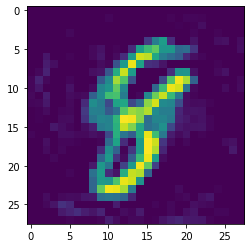

In [171]:
n_im_thresh = n_im.clone()
n_im_thresh[n_im_thresh < 0.01] = 0
plt.imshow(n_im_thresh)

In [166]:
softmax(model(n_im.reshape(-1).unsqueeze(0).to(device)))

/fs/class-projects/fall2021/cmsc828w/cs828w04/anaconda3/envs/class_project/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[1.9606e-07, 1.3858e-09, 3.6096e-06, 6.2097e-04, 5.1499e-04, 4.2711e-06,
         1.1207e-07, 5.0016e-08, 8.4643e-02, 9.1421e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [172]:
softmax(model(n_im_thresh.reshape(-1).unsqueeze(0).to(device)))

/fs/class-projects/fall2021/cmsc828w/cs828w04/anaconda3/envs/class_project/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[2.0902e-07, 1.4173e-09, 3.5898e-06, 6.3405e-04, 5.6011e-04, 4.4499e-06,
         1.2151e-07, 4.4693e-08, 9.0826e-02, 9.0797e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [8]:
images = images.reshape(-1, 28, 28)

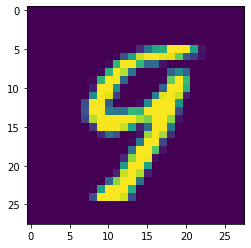

In [9]:
plt.imshow(images[1].cpu().numpy())

In [6]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 98.39 %
